In [1]:
from __future__ import absolute_import, division, print_function
import uproot
import numpy as np
import matplotlib.pyplot as plt

# energyflow imports
import energyflow as ef
from energyflow.archs import *
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_dir = '/global/homes/s/sambt/Jets/optimal-classifiers/event-generation/src/'
h2gg = uproot.open(data_dir+'H2gg-ee-50k.root')['EventTree']
h2qq = uproot.open(data_dir+'H2qqbar-ee-50k.root')['EventTree']

nev_h2gg = h2gg.numentries
nev_h2qq = h2qq.numentries

44

In [3]:
#load pT, eta, phi of leading jet constituents
gjet_pt = h2gg.array("plead_constit_pt")
gjet_eta = h2gg.array("plead_constit_eta")
gjet_phi = h2gg.array("plead_constit_phi")

qjet_pt = h2qq.array("plead_constit_pt")
qjet_eta = h2qq.array("plead_constit_eta")
qjet_phi = h2qq.array("plead_constit_phi")

#only select leading jet info
gjet_pt = gjet_pt[gjet_pt.any()]
gjet_eta = gjet_eta[gjet_eta.any()]
gjet_phi = gjet_phi[gjet_phi.any()]

qjet_pt = qjet_pt[qjet_pt.any()]
qjet_eta = qjet_eta[qjet_eta.any()]
qjet_phi = qjet_phi[qjet_phi.any()]

In [4]:
#combine quark & gluon datasets
max_len = np.max((np.max(h2qq.array("plead_mult")),np.max(h2gg.array("plead_mult"))))
quarks = np.array([[[qjet_pt[i,j],qjet_eta[i,j],qjet_phi[i,j]] if j < np.size(qjet_pt[i]) else [0,0,0] for j in range(max_len)] for i in range(np.size(qjet_pt))])
gluons = np.array([[[gjet_pt[i,j],gjet_eta[i,j],gjet_phi[i,j]] if j < np.size(gjet_pt[i]) else [0,0,0] for j in range(max_len)] for i in range(np.size(gjet_pt))])

In [5]:
max_len

44

In [131]:
#make vectors with truth labels, combine q & g samples, shuffle
quark_labs = np.ones(np.size(quarks,axis=0))
glu_labs = np.zeros(np.size(gluons,axis=0))

X = np.concatenate((quarks,gluons))
y = np.concatenate((quark_labs,glu_labs))

shuf = np.arange(np.size(X,axis=0))
np.random.shuffle(shuf)

X = X[shuf]
y = y[shuf]

In [132]:
#network parameters
train, test, val = 50000, 10000, 20000
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
num_epoch = 5
batch_size = 500

#convert quark/gluon labels to categorical
Y = to_categorical(y,num_classes=2)

In [133]:
# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

Finished preprocessing


In [137]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')

Done train/val/test split


In [138]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

Model summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
_____________________________________________________________________________


PFN AUC: 0.7949957385062936



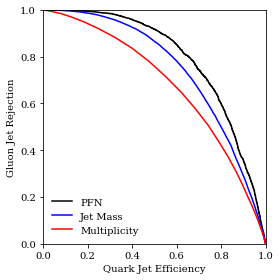

In [139]:
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()